# EDA 004 - DeepStrain - Initial approach

We were pretty used to working with Voxelmorph - we found a neat way of transforming images into numpy, and using the network to find displacement and strain. DeepStrain was trained with NIFTI format and we have to start anew. Moreso, we must check if we know how to use the technique. Once we have our feet in firm land, we will start with images from the dataset they used (cMAC) and then we will move further down the path with an additional dataset (cMAC) which has the ground truth for both movement and strain. Once we get there, we will compare the results from the trained models and the ground truth, aside from computing times, to check if the technique is suitable for our needs.

## Objectives 📋

This analysis has the following goals:
- Load and setup DeepStrain models from what the author provides.
- Understand the image formats we need to use to perform predictions using DeepStrain.
- Reproduce results on an already used dataset (cMAC).
- Try the methodology on cMAC and compare with the ground truth.
- Measure CPU&Memory consumption to check for suitability.

## Imports ⚙️

In [1]:
import glob
import os
import time
from itertools import cycle

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import SimpleITK as sitk
import tensorflow as tf
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy.ndimage import center_of_mass
from tensorflow.keras.optimizers import Adam
from tvtk.api import tvtk

from models import deep_strain_model
from utils import myocardial_strain
from datasets.nifti_dataset import resample_nifti
from datasets.base_dataset import _roll2center_crop

## Data loading & preprocessing 📈

We need to load images from a certain patient of the cMAC/cMAC dataset. To do so:

- We load the `.mhd` images for images and segmentations.
- We join them into `.nii` 4d images.

Note: by default we will use CarSON to get segmentations, therefore, we won't load segmentations into a nifti.


In [2]:
convert_to_nifti = False
convert_segmentations = False
DATASET_FOLDER = "/Users/yhibo/Downloads/MHD_Data"

patients = [f"v{p}" for p in range(1, 17) if p != 3]
#patients = ["v16"]
if convert_to_nifti:
    for patient in patients:
        cmac_folder = os.path.join(DATASET_FOLDER, patient, "cSAX")
        seg_folder = os.path.join(DATASET_FOLDER, patient, "SegmentationNN")
        csax_images = (
            [
                sitk.ReadImage(os.path.join(cmac_folder, f))
                for f in natsorted(os.listdir(cmac_folder))
                if f.endswith(".mhd") and f.startswith(f"{patient}_cSAX_time")
            ]
        )
        origin = csax_images[0].GetOrigin()
        spacing = csax_images[0].GetSpacing()

        sitk.WriteImage(sitk.JoinSeries(csax_images), f"images/cMAC/{patient}.nii.gz")

        if convert_segmentations:
            seg_images = (
                [
                    sitk.ReadImage(os.path.join(seg_folder, f))
                    for f in natsorted(os.listdir(seg_folder))
                    if f.endswith(".mhd") and f.startswith(f"{patient}_cSAX")
                ]
            )
            for seg_im in seg_images:
                seg_im.SetOrigin(origin)
                seg_im.SetSpacing(spacing)
            sitk.WriteImage(sitk.JoinSeries(seg_images), f"images/cMAC/{patient}_seg.nii.gz")

## Segmentation

Only needed if we don't want to use the segmentation we already have from other methods.

Now that we have our images in the correct format to use them within the DeepStrain workflow, we must run the segmentations on images (grab the ground truth on all of them) and save them to disk, using CarSON.



## Segmentation

In [3]:
def normalize(x, axis=(0,1,2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x-mu)/(sd+1e-8)

def get_mask(V):
    nx, ny, nz, nt = V.shape
    
    M = np.zeros((nx,ny,nz,nt))
    v = V.transpose((2,3,0,1)).reshape((-1,nx,ny)) # (nz*nt,nx,ny)
    v = normalize(v)
    for t in range(nt):
        for z in range(nz):
            m = netS(v[z*nt+t,nx//2-64:nx//2+64,ny//2-64:ny//2+64][None, ..., None])
            M[nx//2-64:nx//2+64,ny//2-64:ny//2+64, z, t] += np.argmax(m, -1).transpose((1,2,0)).reshape((128,128))
    return M

class Options():
    
    def __init__(self):
        
        self.datadir = '../../../../datasets/CMAC/raw'
        self.isTrain = False
        self.image_shape = (128,128,1)
        self.nlabels = 4
        self.pretrained_models_netS  = 'models/carson_Jan2021.h5'
        self.pretrained_models_netME = 'models/carmen_Jan2021.h5'
        
opt = Options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netS  = model.get_netS()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-17 22:22:48.744709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-17 22:22:48.745521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


v1


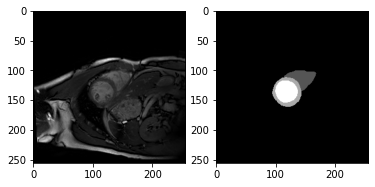

v2
v4
v5
v6
v7
v8
v9
v10
v11
v12
v13
v14
v15
v16


In [4]:
from datasets import base_dataset

tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_logical_devices('GPU')
if gpus:
    for patient in patients:
        print(patient)
        V_nifti = nib.load(f'images/cMAC/{patient}.nii.gz')
        V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=None)

        V = V_nifti_resampled.get_fdata()
        V = normalize(V, axis=(0,1))
        M = get_mask(V)

        # now we calculate center of mass using the first frame as reference as before.
        center_resampled = center_of_mass(M[:,:,:,0]==2)
        V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
        M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
        center_resampled_256x256 = center_of_mass(M==3)

        # we save all this info to invert the segmentation bask to its original location/resolution
        nifti_info = {'affine'           : V_nifti.affine,
                        'affine_resampled' : V_nifti_resampled.affine,
                        'zooms'            : V_nifti.header.get_zooms(),
                        'zooms_resampled'  : V_nifti_resampled.header.get_zooms(),
                        'shape'            : V_nifti.shape,
                        'shape_resampled'  : V_nifti_resampled.shape,
                        'center_resampled' : center_resampled,
                        'center_resampled_256x256' : center_resampled_256x256} 

        M = get_mask(V)[128-64:128+64,128-64:128+64]
        M_nifti = base_dataset.convert_back_to_nifti(M, nifti_info, inv_256x256=True, order=1, mode='nearest')

        if patient == "v1":
            plt.subplot(121); plt.imshow(V_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.subplot(122); plt.imshow(M_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.show()

        # easy. Let's save the results now. 
        M_nifti.to_filename(f"images/cMAC/{patient}_gt.nii.gz")  

## Motion estimation

Once we have the images correctly saved to niftis and segmentations were obtained (either through CarSON or another method, and always saved in the right format) we can run the motion estimation.



In [4]:
class Options():
    
    def __init__(self):
        
        self.datadir = '../../../../datasets/CMAC/raw'
        self.isTrain = False
        self.volume_shape = (128,128,16,1)
        self.pretrained_models_netS  = 'models/carson_Jan2021.h5'
        self.pretrained_models_netME = 'models/carmen_Jan2021.h5'
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

In [6]:
from datasets import base_dataset
for patient in patients:
    V_nifti = nib.load(f"images/cMAC/{patient}.nii.gz")
    M_nifti = nib.load(f"images/cMAC/{patient}_gt.nii.gz")

    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti_resampled = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)

    V = V_nifti_resampled.get_fdata()
    M = M_nifti_resampled.get_fdata()

    center = center_of_mass(M_nifti_resampled.get_fdata()[:,:,:,0]==2)
    V = base_dataset.pad_256x256(V)
    M = base_dataset.pad_256x256(M)

    V = _roll2center_crop(x=V, center=center)
    M = _roll2center_crop(x=M, center=center)

    # model was trained with cine data from base to apex.
    I = np.argmax((M==1).sum(axis=(0,1,3)))
    if I > M.shape[2]//2:
        print('Apex to Base. Inverting.')
        V = V[:,:,::-1]
        M = M[:,:,::-1]

    V = normalize(V, axis=(0,1,2))
    mask_end_diastole = M[..., 0]
    y_t = []
    strain_t = []
    for t in range(30):
        V_0 = V[...,0][None,...,None]
        V_t = V[...,t][None,...,None]
        y_t.append(gaussian_filter(netME([V_0, V_t]).numpy(), sigma=(0,2,2,0,0)))
        strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[t][0,:,:,:,:])
        strain.calculate_strain(lv_label=2)

        strain_t.append([strain.Err[strain.mask_rot == 2].mean(), strain.Ecc[strain.mask_rot == 2].mean()])
    
    np.save(f"results/cMAC/dfield_{patient}.npy", np.asarray(y_t))
    np.save(f"results/cMAC/strain_{patient}.npy", np.asarray(strain_t))
    



Apex to Base. Inverting.
Apex to Base. Inverting.
Apex to Base. Inverting.


KeyboardInterrupt: 

In [35]:
dfield = np.load("results/cMAC/dfield_v1.npy")


In [36]:
dfield[11, 0, ..., 0].shape

(128, 128, 16)

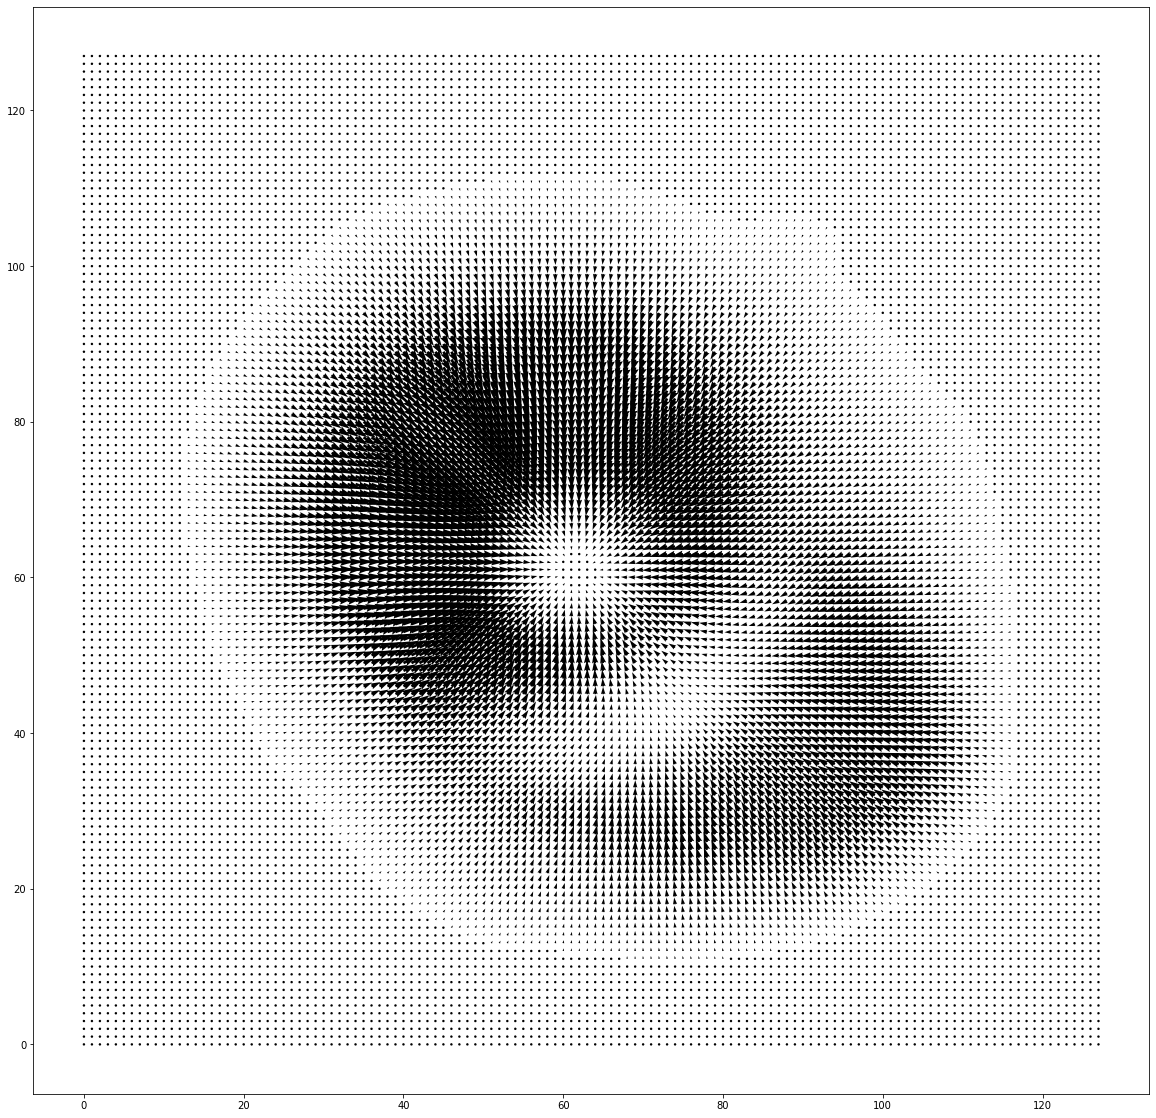

In [37]:
plt.figure(figsize=(20,20))
x = np.arange(128)
y = np.arange(128)
X, Y = np.meshgrid(x, y)

plt.quiver(X, Y, dfield[11, 0, ..., 7, 1],  dfield[11, 0, ..., 7, 0])

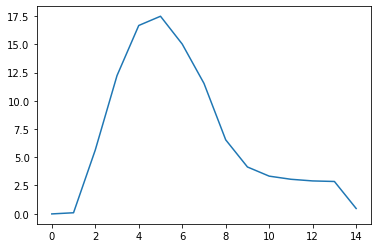

In [20]:
strain = np.load("results/cMAC/strain_v10.npy")
plt.plot(100*strain[::2, 0])
plt.show()